# FINETUNING PRETRANED GPT MODEL FOR INSTRUCTIONS


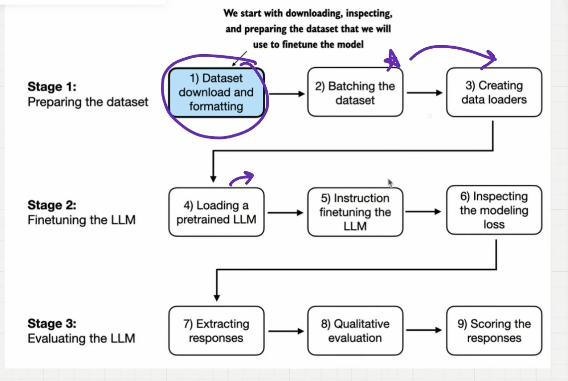

# STEP 1) DATASET PREPARATION


In [ ]:
from google.colab import files
import json
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"File uploaded: {file_name}")
with open(file_name, "r", encoding="utf-8") as f:
    data = json.load(f)



Saving datatset.json to datatset (1).json
File uploaded: datatset (1).json


In [ ]:
print(f"Successfully loaded {len(data)} samples.")
print("Example sample:\n")
print(data[0])

Successfully loaded 1100 samples.
Example sample:

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}


# Converting Instruction into ALPACA Format

Github Link: https://github.com/tatsu-lab/stanford_alpaca

* For training purposes Alpaca is better and for evaluating or improving robustness PIE 3 is better

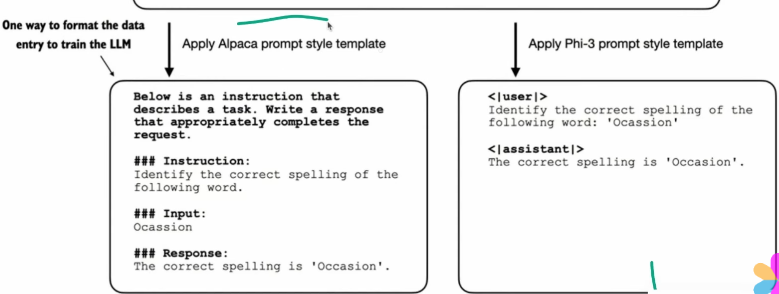

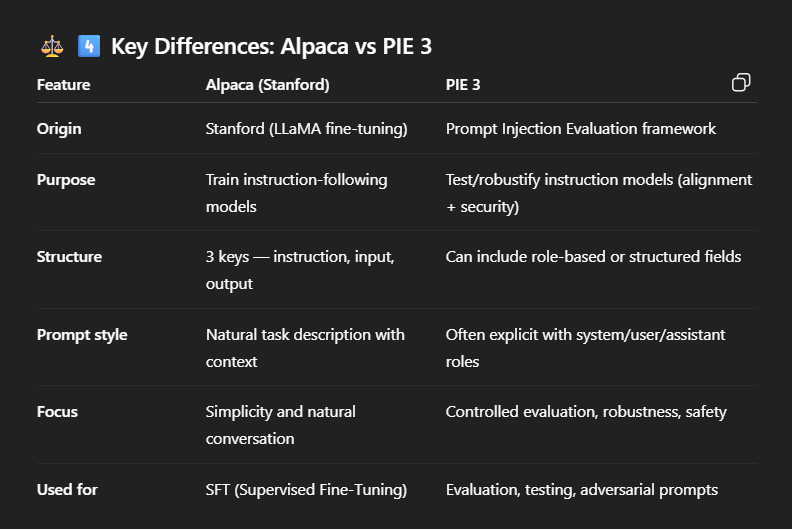

In [ ]:
def formatInput(entry):
  instructionText = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appropriately completes the request.\n\n"
      f"\n\n### Instruction: \n{entry['instruction']}"
  )
  inputText = f"\n\n### Input: \n{entry['input']}" if entry["input"] else ""

  return instructionText + inputText

In [ ]:
# testing with data with input
modelInput = formatInput(data[50])
desiredResponse = f"\n\n### Response:\n{data[50]['output']}"
print(modelInput)
print(desiredResponse)

Below is an instruction that describes a task. Write a response that appropriately completes the request.



### Instruction: 
Identify the correct spelling of the following word.

### Input: 
Ocassion


### Response:
The correct spelling is 'Occasion.'


In [ ]:
# testing with data with only instruction and response
modelInput = formatInput(data[999])
desiredResponse = f"\n\n### Response:\n{data[100]['output']}"
print(modelInput)
print(desiredResponse)

Below is an instruction that describes a task. Write a response that appropriately completes the request.



### Instruction: 
What is an antonym of 'complicated'?


### Response:
A synonym for "happiness" is "joy."


# Splitting Dataset

In [ ]:
trainingPortion = int(len(data)*0.85)
testingPortion = int(len(data) * 0.1)
validationPortion = len(data) - trainingPortion - testingPortion

trainingData = data[:trainingPortion]
testingData = data[trainingPortion:trainingPortion + testingPortion]
validationData = data[trainingPortion + testingPortion:]

print("Training Dataset Length:" ,len(trainingData))
print("Testing  Dataset Length:" ,len(testingData))
print("Validation Dataset Length:" ,len(validationData))

Training Dataset Length: 935
Testing  Dataset Length: 110
Validation Dataset Length: 55


# STEP 2) BATCHING THE DATASET
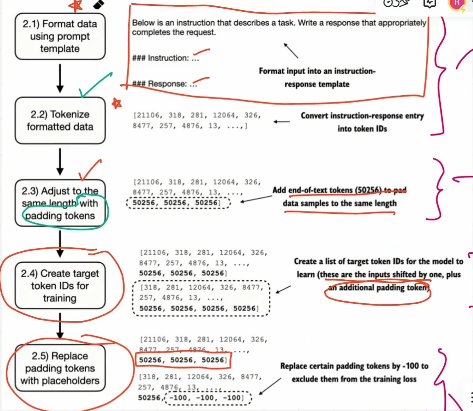

In [ ]:
import importlib
import tiktoken
import torch
import torch.nn as nn
import numpy as np


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data

    self.encodedTexts = []
    for entry in data:
      intructionAndInput = formatInput(entry)
      responseText = f"\n\n### Response:\n{entry['output']}"
      fullText = intructionAndInput + responseText
      self.encodedTexts.append(tokenizer.encode(fullText))
  def __getitem__(self, index):
    return self.encodedTexts[index]
  def __len__(self):
    return len(self.data)

In [ ]:
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


# Collate Function For Padding

1) Finds the longest sequence in the batch
2) Pad and prepares input
3) Remove extra padded token added earlier
4) Convert list of inputs to tensor and transfer to target device

In [ ]:
import torch

def collateDraft1(batch, padTokenId=50256, device="cpu"):
    'Step 1'
    maxLenInBatch = max(len(item) + 1 for item in batch)
    inputLists = []
    targetLists = []

    'Step 2'
    for item in batch:
        newItem = item.copy()
        newItem += [padTokenId]
        padded = newItem + [padTokenId] * (maxLenInBatch - len(newItem))

        'Step 3'
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputLists.append(inputs)
        targetLists.append(targets)

    'Step 4'
    inputsTensor = torch.stack(inputLists).to(device)
    targetsTensor = torch.stack(targetLists).to(device)
    return inputsTensor, targetsTensor


In [ ]:
ip1 = [0,1,2,3,4]
ip2 = [5, 6]
ip3 = [7,8,9]

batch = [ip1, ip2, ip3]
inputs, targets = collateDraft1(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


# Replacing padded tokens with placeholders


In [ ]:
def finalCollate(
    batch,
    padTokenId=50256,
    ignore_index = -100,
    allowed_max_length = None,
    device="cpu"
):
    maxLenInBatch = max(len(item) + 1 for item in batch)
    inputList, targetList = [], []
    for item in batch:
        newItem = item.copy()
        newItem += [padTokenId]
        padded = newItem + [padTokenId] * (maxLenInBatch - len(newItem))

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        mask = targets == padTokenId  # Mask all 50256 tokens
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
          targets[indices[1:]] = ignore_index  # Keep first paded token and replace all other

        if allowed_max_length is not None:
          inputs = inputs[:allowed_max_length]
          targets = targets[:allowed_max_length]

        inputList.append(inputs)
        targetList.append(targets)

    inputsTensor = torch.stack(inputList).to(device)
    targetsTensor = torch.stack(targetList).to(device)
    return inputsTensor, targetsTensor



In [ ]:
ip1 = [0,1,2,3,4]
ip2 = [5, 6]
ip3 = [7,8,9]

batch = [ip1, ip2, ip3]
inputs, targets = finalCollate(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


# STEP 3) CREATING DATALOADERS FROM AN INSTRUCTION DATASET

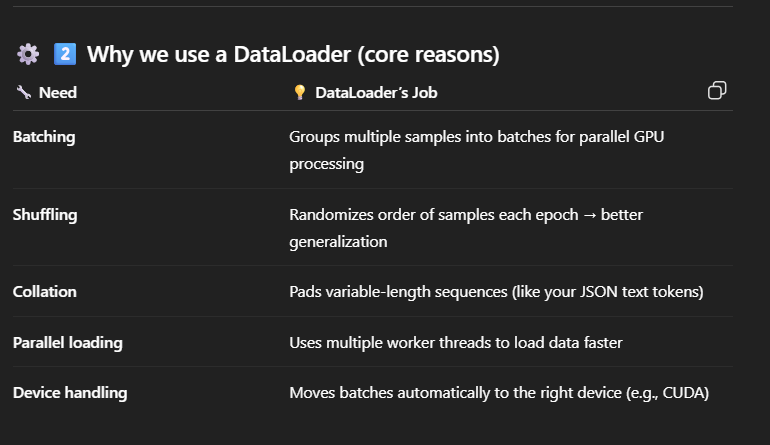

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 2

torch.manual_seed(123)

trainingDataset = InstructionDataset(trainingData, tokenizer)
trainingLoader = DataLoader(
    trainingDataset,
    batch_size= batch_size,
    collate_fn = finalCollate,
    shuffle = True,
    drop_last= True,
    num_workers = num_workers
)

validationDataset = InstructionDataset(validationData, tokenizer)
validationLoader = DataLoader(
    validationDataset,
    batch_size = batch_size,
    collate_fn = finalCollate,
    shuffle = False,
    drop_last = False,
    num_workers = num_workers

)

testingDataset = InstructionDataset(testingData, tokenizer)
testingLoader = DataLoader(
    testingDataset,
    batch_size = batch_size,
    collate_fn = finalCollate,
    shuffle = False,
    drop_last = False,
    num_workers = num_workers
)

In [ ]:
print("Train Loader")
for inputs, targets in trainingLoader:
  print(inputs.shape, targets.shape)

Train Loader
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 70]) torch.S

# STEP 4) LOADING PRETRAINED MODEL

In [ ]:
'Layer Normalization'
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim =-1, keepdim= True) # Mean Along Column
    var = x.var(dim =-1, keepdim= True, unbiased = False) # Variance Along Column
    normalizedX = (x-mean)/torch.sqrt(var+self.eps)  # Eps is small constant to prevent dividing by 0 during normalization
    return self.scale * normalizedX + self.shift

# Scale and shift are two trainable params of same dim as input that LLM automatically adjusts during training and this improves models performance on its training task

'GELU ACTIVATION FUNCTION'
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

'Feed Forward Neural Network'
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), #Expansion
        nn.GELU(), # Activation
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]), # Compression
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
'Masked Self Attention'
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
'TRANSFORMER BLOCK'
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        dropout = cfg["drop_rate"],
        num_heads = cfg["n_heads"],
        qkv_bias= cfg["qkv_bias"]
    )
    self.feedforwardNN = FeedForward(cfg)
    self.normalization1 = LayerNorm(cfg["emb_dim"])
    self.normalization2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.normalization1(x)
    x = self.attention(x)  #Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = shortcut + x # Add the original input block

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.normalization2(x)
    x = self.feedforwardNN(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tokenEmbeddings = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.positionalEmbeddings = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #(1024x768)
    self.dropuoutEmbeddings = nn.Dropout(cfg["drop_rate"])

    'Transformer Block'
    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
   )
    'Layer Normalization'
    self.finalNormalization = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"],
        cfg["vocab_size"], bias = False
    )

  def forward(self, inIdx):
    batchSize, seqLen  = inIdx.shape
    tokenEmbeddings = self.tokenEmbeddings(inIdx)
    positionalEmbeddings = self.positionalEmbeddings(torch.arange(seqLen, device = inIdx.device))
    x = tokenEmbeddings + positionalEmbeddings
    x = self.dropuoutEmbeddings(x)
    x = self.trf_blocks(x)
    x = self.finalNormalization(x)
    logits = self.out_head(x)
    return logits

In [ ]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch, Left: {left.shape}, Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [ ]:
def loadWeights(gpt, params):
    gpt.positionalEmbeddings.weight = assign(gpt.positionalEmbeddings.weight, params["wpe"])
    gpt.tokenEmbeddings.weight = assign(gpt.tokenEmbeddings.weight, params["wte"])

    for b in range(len(params["blocks"])):
        # Split Q, K, V weights
        q_w, k_w, v_w = np.split(
            params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1
        )
        gpt.trf_blocks[b].attention.W_query.weight = assign(
            gpt.trf_blocks[b].attention.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].attention.W_key.weight = assign(
            gpt.trf_blocks[b].attention.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].attention.W_value.weight = assign(
            gpt.trf_blocks[b].attention.W_value.weight, v_w.T
        )

        # Biases
        q_b, k_b, v_b = np.split(
            params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1
        )
        gpt.trf_blocks[b].attention.W_query.bias = assign(
            gpt.trf_blocks[b].attention.W_query.bias, q_b
        )
        gpt.trf_blocks[b].attention.W_key.bias = assign(
            gpt.trf_blocks[b].attention.W_key.bias, k_b
        )
        gpt.trf_blocks[b].attention.W_value.bias = assign(
            gpt.trf_blocks[b].attention.W_value.bias, v_b
        )

        # Output projection
        gpt.trf_blocks[b].attention.out_proj.weight = assign(
            gpt.trf_blocks[b].attention.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].attention.out_proj.bias = assign(
            gpt.trf_blocks[b].attention.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        # FeedForward
        gpt.trf_blocks[b].feedforwardNN.layers[0].weight = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].feedforwardNN.layers[0].bias = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].feedforwardNN.layers[2].weight = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].feedforwardNN.layers[2].bias = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        # LayerNorms
        gpt.trf_blocks[b].normalization1.scale = assign(
            gpt.trf_blocks[b].normalization1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].normalization1.shift = assign(
            gpt.trf_blocks[b].normalization1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].normalization2.scale = assign(
            gpt.trf_blocks[b].normalization2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].normalization2.shift = assign(
            gpt.trf_blocks[b].normalization2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    # Final LayerNorm and output head
    gpt.finalNormalization.scale = assign(gpt.finalNormalization.scale, params["g"])
    gpt.finalNormalization.shift = assign(gpt.finalNormalization.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":256, # 1024-->256 (for local pc)
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): Tran

# SETTING UP GPT MODEL

In [ ]:
from google.colab import files
uploaded = files.upload()  # select gpt_download3.py

Saving gpt_download3.py to gpt_download3 (2).py


In [ ]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();